# Figure 13

FALTA ESTO!!!!

In [ ]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import PIL
import numpy as np
import pandas as pd
import seaborn as sns
from io import BytesIO
import scipy.stats as stats
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from collections import defaultdict
from statsmodels.formula.api import ols

from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Utils.bar_utils import BarRenderer

In [170]:
# Load human data
file_name = 'all_data.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
data['model'] = data.apply(lambda row: f"{row['room']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
data.drop(columns=['room', 'date', 'timeup', 'time', 'attendance', 'ac_score'], inplace=True)
data.sort_values(by=['num_players', 'threshold'], inplace=True)
data = data[data['threshold'] != 1]
data['num_players'] = data['num_players'].astype(int)
data['round'] = data['round'].astype(int)
data['decision'] = data['decision'].astype(int)
data['group'] = data['group'].apply(lambda x: x.split('-')[0] if 'Grupo' not in x else x.split('-')[1])
data.drop(columns=['choice'], inplace=True)
print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))
data.head(2)

Loading data from /Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/human/all_data.csv...
Group sizes: 2, 3, 4, 5, 6, 7, 8, 9, 11, 12
Number of groups: 51


,source,treatment,group,round,player,score,threshold,num_players,decision,model
0,humans,score + grid,0001,1,405186428721292,0.0,0.5,2,0,Grupo-0001-2-0.50
1,humans,score + grid,0001,1,728608683559397,1.0,0.5,2,1,Grupo-0001-2-0.50


Change round to round within session

In [171]:
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions

group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)


def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
data['group'] = data.apply(lambda row: f"{row['group']}-{row['session']}", axis=1)

data = data[data['round'] <= 30]

data.head(2)

,source,treatment,group,round,player,score,threshold,num_players,decision,model,session
0,humans,score + grid,0001-1,0,405186428721292,0.0,0.5,2,0,Grupo-0001-2-0.50,1
1,humans,score + grid,0001-1,0,728608683559397,1.0,0.5,2,1,Grupo-0001-2-0.50,1


In [172]:
data['session'].value_counts()

session
1    6004
2    4712
3    3480
Name: count, dtype: int64

### Efficiency and alternation index

In [173]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality'],
    T=15
)
df = gm.get_measurements()

In [174]:
alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation_index'] = alt_index(df)
print('Num. of sessions:', len(df))
df.head(2)

Num. of sessions: 99


,model,treatment,threshold,num_players,group,efficiency,bounded_efficiency,entropy,conditional_entropy,inequality,alternation_index
0,11-8-0.38,downwards,0.375,8,11-3,-0.062500,-0.166667,0.500000,-0.000000,0.081832,7.669592e-08
1,11-8-0.62,downwards,0.625,8,11-2,0.148438,0.237500,0.453125,0.033333,0.170141,1.387278e-06


In [175]:
df['predicted_class'] = alt_index.classify(df)
df_ = df.groupby('num_players')['predicted_class'].value_counts(normalize=True).reset_index()
df_categories = pd.pivot_table(
    data=df_,
    index='num_players',
    columns='predicted_class',
    values='proportion'
).fillna('-')
df_categories

predicted_class,alternation,mixed,random,segmentation
num_players,,,,
2,0.217391,-,0.739130,0.043478
3,0.083333,-,0.916667,-
4,-,0.041667,0.916667,0.041667
5,-,-,1.000000,-
6,-,-,1.000000,-
7,-,-,1.000000,-
8,-,-,1.000000,-
9,-,-,1.000000,-
11,-,-,1.000000,-


In [176]:
df['predicted_class'].value_counts(normalize=True).reset_index()

,predicted_class,proportion
0,random,0.909091
1,alternation,0.060606
2,segmentation,0.020202
3,mixed,0.010101


### Best performing groups

In [177]:
print(df['bounded_efficiency'].describe())

count    99.000000
mean     -0.033215
std       0.632597
min      -1.937500
25%      -0.500000
50%       0.062500
75%       0.458333
max       1.000000
Name: bounded_efficiency, dtype: float64


In [187]:
df_best = df[df['bounded_efficiency'] > 0.5]
# df_best['model'] = df_best.apply(lambda row: f"{row['model']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
df_best.sort_values(by=['num_players'], inplace=True)
print('Num. of best sessions:', len(df_best))
df_best

Num. of best sessions: 20


,model,treatment,threshold,num_players,group,efficiency,bounded_efficiency,entropy,conditional_entropy,inequality,alternation_index,predicted_class
96,Grupo-0021-2-0.50,only score,0.500000,2,0021-1,0.343750,0.687500,0.750807,0.525815,0.574524,2.174182e-14,segmentation
89,Grupo-0014-2-0.50,only score,0.500000,2,0014-1,0.500000,1.000000,0.348106,0.351839,0.000000,9.757532e-01,alternation
87,Grupo-0012-2-0.50,only score,0.500000,2,0012-1,0.468750,0.937500,0.623778,0.437314,0.044194,8.336992e-01,alternation
90,Grupo-0015-2-0.50,only score,0.500000,2,0015-1,0.312500,0.625000,0.683157,0.580330,0.000000,4.943651e-01,random
83,Grupo-0008-2-0.50,score + grid,0.500000,2,0008-1,0.375000,0.750000,0.711897,0.405493,0.000000,8.753366e-01,alternation
81,Grupo-0006-2-0.50,score + grid,0.500000,2,0006-1,0.500000,1.000000,0.500000,-0.000000,0.000000,9.757532e-01,alternation
76,Grupo-0001-2-0.50,score + grid,0.500000,2,0001-1,0.500000,1.000000,0.477217,0.427327,0.000000,9.757532e-01,alternation
80,Grupo-0005-2-0.50,score + grid,0.500000,2,0005-1,0.406250,0.812500,0.623778,0.254516,0.044194,7.075795e-01,random
39,30-3-0.33,downwards,0.333333,3,30-2,0.270833,0.812500,0.607731,0.080214,0.036084,7.752092e-01,alternation
50,34-3-0.67,upwards,0.666667,3,34-2,0.625000,0.937500,0.432932,0.217210,0.375000,2.992869e-07,random


### Panel A: Playout examples

(5, 4)


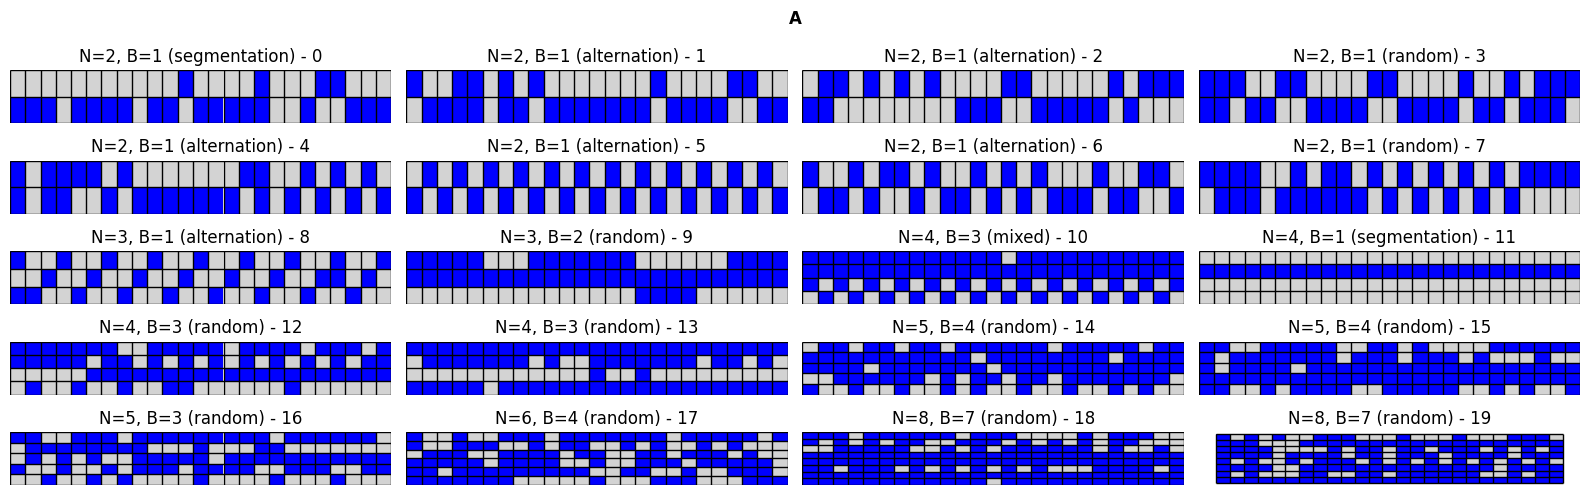

In [ ]:
groups = df_best['model'].unique()

grid = Grid(len(groups), vertical=True)

fig, axes = plt.subplots(
    grid.rows, grid.cols, 
    figsize=(grid.cols*4, grid.rows),
    tight_layout=True
)

for i, group in enumerate(groups):
    df_aux = df_best[df_best['model'] == group]
    df_aux_aux = data[data['model'] == group]
    N = df_aux_aux['num_players'].values[0]
    B = int(df_aux_aux['threshold'].values[0] * N)
    classification = df_aux['predicted_class'].values[0]
    bar_renderer = BarRenderer(data=df_aux_aux)
    bar_renderer.render(
        ax=axes[grid.index_to_pair(i)],
        title=f"N={N}, B={B} ({classification})",
        num_rounds=25
    )

# Convert figure to image array
fig.suptitle("A", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_A = np.array(pil_image)

### Average score per round

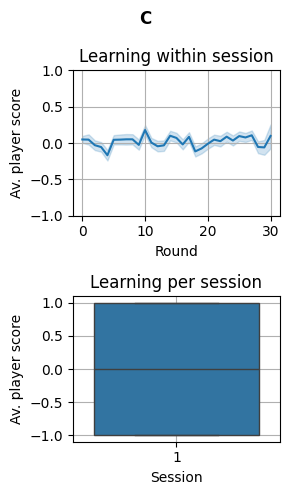

In [162]:
fig, ax = plt.subplots(
    2,1, 
    figsize=(3,5), 
    tight_layout=True,
    sharey=False
)

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', data=data,
    ci=95, ax=ax[0]
)
ax[0].set_xlabel('Round')
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Learning within session")
ax[0].grid()
ax[0].set_ylim([-1,1])

# Learning: average score increases per session
sns.boxplot(
    x='session', y='score', 
    data=data, ax=ax[1],
)
ax[1].set_xlabel('Session')
ax[1].set_ylabel("Av. player score")
ax[1].set_title("Learning per session")
ax[1].grid()
# ax[1].set_ylim([-1,1])

# Convert figure to image array
fig.suptitle("C", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_C = np.array(pil_image)

Pearson round vs score

In [143]:
pearson_coef, p_value = stats.pearsonr(data['score'], data['round'])

print(f"Pearson correlation coefficient: {pearson_coef}")
print(f"P-value: {p_value}")
print(f"{pearson_coef:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: 0.0671824671855809
P-value: 4.7428742199555994e-17
0.067 (p=0.000)


Difference in means between session

In [144]:
# Get the unique session labels
sessions = data['session'].unique()

# Extract the scores for each session
scores_by_session = [data[data['session'] == session]['score'] for session in sessions]

# Perform the Kruskal-Wallis H-test
h_stat, p_value = stats.kruskal(*scores_by_session)

print(f"Kruskal-Wallis H statistic: {h_stat}")
print(f"P-value: {p_value}")
print(f"H={h_stat:.3f} (p={p_value:.3f})")

Kruskal-Wallis H statistic: 321.41913048243407
P-value: 1.6022217637392937e-70
H=321.419 (p=0.000)


### bounded efficiency vs. inequality

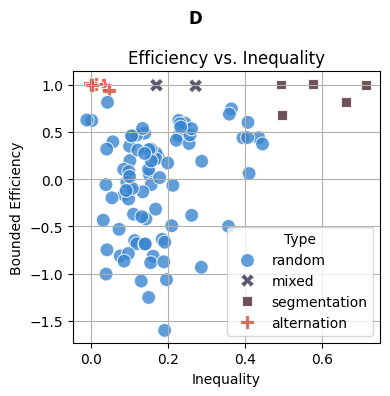

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), tight_layout=True)
# Scatter plot bounded efficiency vs. inequality
df_jitter = df.copy()
n = df_jitter.shape[0]
df_jitter['inequality'] = df_jitter['inequality'] + np.random.normal(0,0.005, n)
df_jitter['bounded_efficiency'] = df_jitter['bounded_efficiency'] + np.random.normal(0,0.005, n)
ax = sns.scatterplot(
    x='inequality', y='bounded_efficiency',
    style='predicted_class', hue='predicted_class',
    data=df_jitter,
    # hue='treatment', style='num_players',
    alpha=0.8, ax=ax,
    palette='icefire',
    s=100
)

ax.set_xlabel('Inequality')
ax.set_ylabel('Bounded Efficiency')
ax.set_title('Efficiency vs. Inequality')
ax.grid()
ax.legend(
    title='Type',
    # labels=['Random', 'Mixed', 'Segmented', 'Alternation'],
    # labels=['random', 'mixed', 'segmentation', 'alternation'],
    
)


# # Show the alternating groups on the top-left corner
# circle = patches.Ellipse(
#     (0.1, 0.82), width=0.2, height=0.3,
#     transform=ax.transAxes, 
#     color='gray', alpha=0.2, 
# )
# ax.add_patch(circle)
# # Add an arrow pointing to the cluster
# ax.annotate(
#     'Alternating\n groups',
#     xy=(0.15, 0.8), xycoords='axes fraction',
#     xytext=(0.15, 0.1), textcoords='axes fraction',
#     arrowprops=dict(facecolor='black', arrowstyle='->'),
#     fontsize=10
# )

# # Show the mixed groups on the top center
# circle = patches.Ellipse(
#     (0.575, 0.88), width=0.5, height=0.25,
#     transform=ax.transAxes, 
#     color='gray', alpha=0.2, 
# )
# ax.add_patch(circle)
# # Add an arrow pointing to the cluster
# ax.annotate(
#     'Mixed\n groups',
#     xy=(0.6, 0.8), xycoords='axes fraction',
#     xytext=(0.6, 0.35), textcoords='axes fraction',
#     arrowprops=dict(facecolor='black', arrowstyle='->'),
#     fontsize=10
# )

# # Show the segmented groups on the top-right corner
# circle = patches.Ellipse(
#     (0.95, 0.875), width=0.1, height=0.25, 
#     transform=ax.transAxes, 
#     color='gray', alpha=0.2
# )
# ax.add_patch(circle)
# # Add an arrow pointing to the cluster
# ax.annotate(
#     'Segmented\n   groups',
#     xy=(0.92, 0.8), xycoords='axes fraction',
#     xytext=(0.65, 0.1), textcoords='axes fraction',
#     arrowprops=dict(facecolor='black', arrowstyle='->'),
#     fontsize=10
# )

# Convert figure to image array
fig.suptitle("D", fontweight="bold")



fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_D = np.array(pil_image)


### Panels C and D

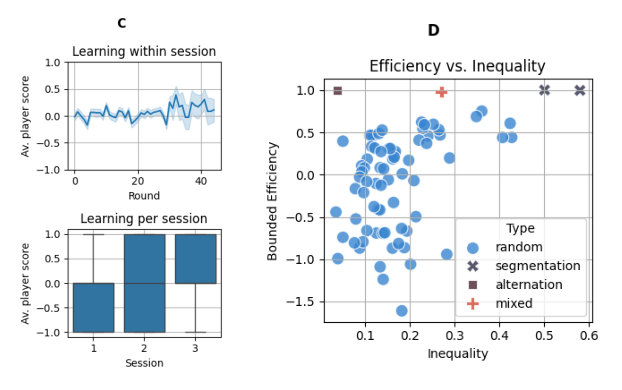

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(7,4), tight_layout=True)

ax[0].imshow(panel_C)  
ax[1].imshow(panel_D)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_C_and_D = np.array(pil_image)

### Panel E --- Influence of threshold and number of players

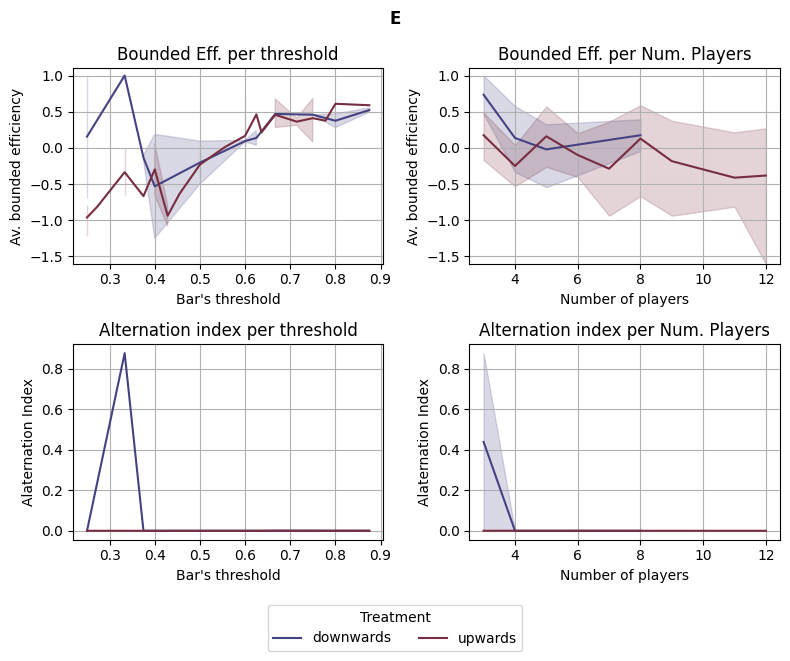

In [50]:
fig, ax = plt.subplots(
    2, 2, 
    figsize=(8,6), 
    tight_layout=True,
    # sharex=True, sharey=True
)

# Efficiency per threshold and treatment
sns.lineplot(
    x='threshold', y='bounded_efficiency',
    hue='treatment',
    data=df, ax=ax[0,0],
    palette='icefire'
)
ax[0,0].set_xlabel("Bar's threshold")
ax[0,0].set_ylabel("Av. bounded efficiency")
ax[0,0].set_title("Bounded Eff. per threshold")
ax[0,0].grid()
ax[0,0].set_ylim([-1.6,1.1])
ax[0,0].legend_.remove()

# Efficiency per number of agents and treatment
sns.lineplot(
    x='num_players', y='bounded_efficiency',
    hue='treatment',
    data=df, ax=ax[0,1],
    palette='icefire'
)
ax[0,1].set_xlabel("Number of players")
ax[0,1].set_ylabel("Av. bounded efficiency")
ax[0,1].set_title("Bounded Eff. per Num. Players")
ax[0,1].grid()
ax[0,1].set_ylim([-1.6,1.1])
ax[0,1].legend_.remove()

# Alternation index per threshold and treatment
sns.lineplot(
    x='threshold', y='alternation_index',
    hue='treatment',
    data=df, ax=ax[1,0],
    palette='icefire'
)
ax[1,0].set_xlabel("Bar's threshold")
ax[1,0].set_ylabel("Alaternation Index")
ax[1,0].set_title("Alternation index per threshold")
ax[1,0].grid()
# ax[1,0].set_ylim([-1,1])
ax[1,0].legend().remove()

# Alternation index per number of agents and treatment
sns.lineplot(
    x='num_players', y='alternation_index',
    hue='treatment',
    data=df, ax=ax[1,1],
    palette='icefire'
)
ax[1,1].set_xlabel("Number of players")
ax[1,1].set_ylabel("Alaternation Index")
ax[1,1].set_title("Alternation index per Num. Players")
ax[1,1].grid()
# ax[1,1].set_ylim([-1,1])
ax[1,1].legend().remove()

# Convert figure to image array
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(.5, -.1),
    ncol=2
)
fig.suptitle("E", fontweight="bold")
# fig.canvas.draw()
# rgba_bytes = fig.canvas.buffer_rgba().tobytes()
# width, height = fig.canvas.get_width_height()
# pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
# fourth_row_array = np.array(pil_image)

buf = BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight', dpi=fig.dpi)
buf.seek(0)

# Read the buffer into a NumPy array
pil_image = Image.open(buf).convert("RGBA")
panel_E = np.array(pil_image)


# All panels for Figure 12

(np.float64(-0.5), np.float64(789.5), np.float64(660.5), np.float64(-0.5))

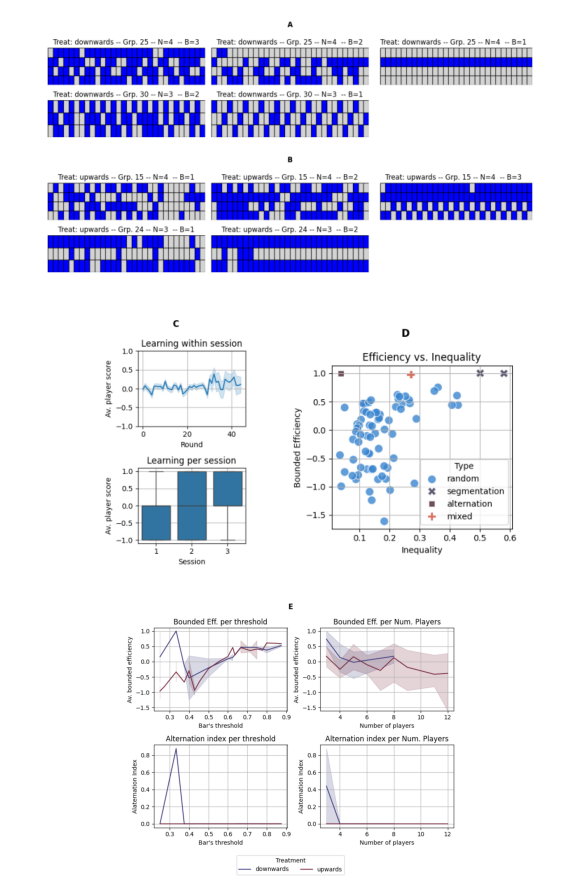

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(6,9), tight_layout=True)

ax[0].imshow(panels_A_and_B)
ax[1].imshow(panels_C_and_D)
ax[2].imshow(panel_E)

ax[0].axis('off')
ax[1].axis('off') 
ax[2].axis('off')



In [61]:
fig.savefig(PATHS['figures_for_paper'] / 'Figure13.png', dpi=300, bbox_inches='tight')

### Regressions

In [53]:
formula = 'score ~ treatment + num_players + threshold + round + session ' 
formula += '+ num_players * threshold + round * session + treatment * threshold + treatment * num_players'
lm = ols(formula, data).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     176.6
Date:                Fri, 01 Aug 2025   Prob (F-statistic):          8.54e-318
Time:                        14:55:11   Log-Likelihood:                -14342.
No. Observations:               13274   AIC:                         2.870e+04
Df Residuals:                   13264   BIC:                         2.878e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [54]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality'],
)
df = gm.get_measurements()

alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation_index'] = alt_index(df)

df.head(2)

,treatment,threshold,num_players,group,efficiency,bounded_efficiency,entropy,conditional_entropy,inequality,alternation_index
0,downwards,0.25,4,18,-0.155172,-0.62069,0.729678,0.339055,0.107211,1.588236e-11
1,downwards,0.25,4,25,0.250000,1.00000,-0.000000,-0.000000,0.500000,2.673815e-11


In [55]:
formula = 'bounded_efficiency ~ treatment + num_players + threshold'
formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
lm = ols(formula, df).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     bounded_efficiency   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     32.13
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           3.77e-18
Time:                        14:55:15   Log-Likelihood:                -21.189
No. Observations:                  76   AIC:                             56.38
Df Residuals:                      69   BIC:                             72.69
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [56]:
formula = 'alternation_index ~ treatment + num_players + threshold'
formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
lm = ols(formula, df).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      alternation_index   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.444
Date:                Fri, 01 Aug 2025   Prob (F-statistic):             0.0335
Time:                        14:55:15   Log-Likelihood:                 222.36
No. Observations:                  76   AIC:                            -430.7
Df Residuals:                      69   BIC:                            -414.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### Check collective action dilemma

In [57]:
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})

group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})

In [58]:
from scipy.stats import pearsonr

In [59]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: 0.3389
P-value: 1.9477e-05
0.339 (p=0.000)


In [60]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: -0.3838
P-value: 4.3793e-02
-0.384 (p=0.044)


---